# Usefule resources:
## OpenCV NLM Example:
https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html

## IPOL
http://www.ipol.im/pub/art/2011/bcm_nlm/

## 2005 IEEE NLM article
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1467423

## NLM OpenCV GitHub:
- https://github.com/opencv/opencv/tree/4.x/modules/photo/src
- https://github.com/opencv/opencv/blob/4.x/modules/photo/src/fast_nlmeans_denoising_invoker.hpp (most important)
- https://github.com/opencv/opencv/blob/4.x/modules/photo/src/fast_nlmeans_denoising_invoker_commons.hpp (utils)

## Image sequencies 
https://static.aminer.org/pdf/PDF/000/317/196/spatio_temporal_wiener_filtering_of_image_sequences_using_a_parametric.pdf  
Page 5: *Unfortunately, this method fails when the standard deviation of the noise exceeds
the contrast of edges.*  
Mostly section 7.1

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.io import imread, imshow
import cv2 as cv
from nlm import denoise_nlm, show_original_with_denoised, denoise_nlm_with_history, compare_img_quality, denoise_nlm_incomplete_with_history
from matplotlib import pyplot as plt


prefix = "/home/martinb/SCHOOL/pv162_project/"
samples_dark_path = prefix + "data/input_images/samples_dark/"

def crop(img):
    return img[5:55, 80:130]

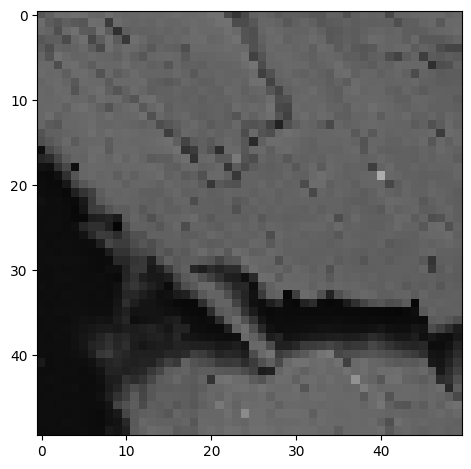

In [2]:
img_gt = imread(prefix + "data/input_images/sample_dark_200x100.png", as_gray=True).astype(np.uint8)
img_gt_float = img_gt.astype(np.float64) / 255
imshow(crop(img_gt))
# img.shape

In [3]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.35 * sd # 0.078 
compare_window_size = 9 # ODD
search_window_size = 27 # ODD! bigger than compare win

In [6]:
i = 0
img = imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.uint8)
img_float = img.astype(np.float64) / 255
denoised_img = denoise_nlm(crop(img_float), search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.30286192893981934s
2/50 rows done, elapsed time: 0.4194955825805664s
3/50 rows done, elapsed time: 0.5448882579803467s
4/50 rows done, elapsed time: 0.6779561042785645s
5/50 rows done, elapsed time: 0.8219504356384277s
6/50 rows done, elapsed time: 0.9722259044647217s
7/50 rows done, elapsed time: 1.1329498291015625s
8/50 rows done, elapsed time: 1.3008966445922852s
9/50 rows done, elapsed time: 1.4812610149383545s
10/50 rows done, elapsed time: 1.6741828918457031s
11/50 rows done, elapsed time: 1.874588966369629s
12/50 rows done, elapsed time: 2.0804336071014404s
13/50 rows done, elapsed time: 2.2934398651123047s
14/50 rows done, elapsed time: 2.5171337127685547s
15/50 rows done, elapsed time: 2.7407212257385254s
16/50 rows done, elapsed time: 2.96683406829834s
17/50 rows done, elapsed time: 3.1979472637176514s
18/50 rows done, elapsed time: 3.4252736568450928s
19/50 rows done, elapsed time: 3.651273488998413s
20/50 rows done, elapsed time: 3.8753230571

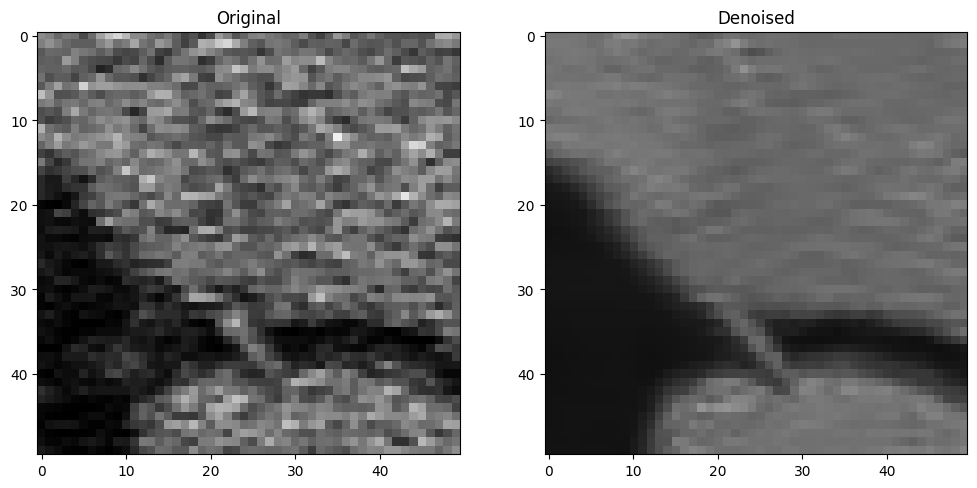

In [7]:
show_original_with_denoised(crop(img_float), denoised_img)

In [8]:
i = 0
img = imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.uint8)
img_float = img.astype(np.float64) / 255
denoised_img = denoise_nlm(crop(img_float), search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.27797460556030273s
2/50 rows done, elapsed time: 0.39744019508361816s
3/50 rows done, elapsed time: 0.525632381439209s
4/50 rows done, elapsed time: 0.6661148071289062s
5/50 rows done, elapsed time: 0.8159842491149902s
6/50 rows done, elapsed time: 0.9705142974853516s
7/50 rows done, elapsed time: 1.1302237510681152s
8/50 rows done, elapsed time: 1.296769380569458s
9/50 rows done, elapsed time: 1.478522777557373s
10/50 rows done, elapsed time: 1.667222499847412s
11/50 rows done, elapsed time: 1.882094144821167s
12/50 rows done, elapsed time: 2.095329523086548s
13/50 rows done, elapsed time: 2.313748836517334s
14/50 rows done, elapsed time: 2.546590566635132s
15/50 rows done, elapsed time: 2.7863311767578125s
16/50 rows done, elapsed time: 3.0209546089172363s
17/50 rows done, elapsed time: 3.2612428665161133s
18/50 rows done, elapsed time: 3.4882254600524902s
19/50 rows done, elapsed time: 3.7148797512054443s
20/50 rows done, elapsed time: 3.9445512294769

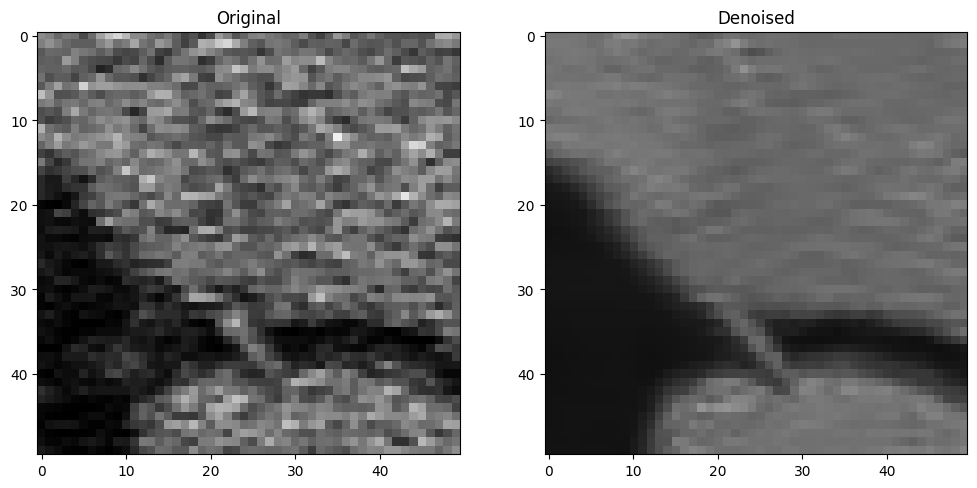

In [9]:
show_original_with_denoised(crop(img_float), denoised_img)

In [10]:
# quality of the denoised img
compare_img_quality(crop(img_float), crop(img_gt_float), denoised_img)

# PSNR
  66.46068772206652
  71.36727261151377
# SSIM
  0.28493636298612834
  0.3814666584130843
# MSE
  0.01468965474817378
  0.004746277207689


In [6]:
# load history
count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))

In [7]:
i = 0
img_0 = crop((imread(samples_dark_path + f"{i}.png", as_gray=True).astype(np.float64)) / 255)
denoised_img_0 = denoise_nlm_with_history(img_0, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.7939462661743164s
2/50 rows done, elapsed time: 1.4298982620239258s
3/50 rows done, elapsed time: 2.1398043632507324s
4/50 rows done, elapsed time: 3.1125481128692627s
5/50 rows done, elapsed time: 3.9588751792907715s


KeyboardInterrupt: 

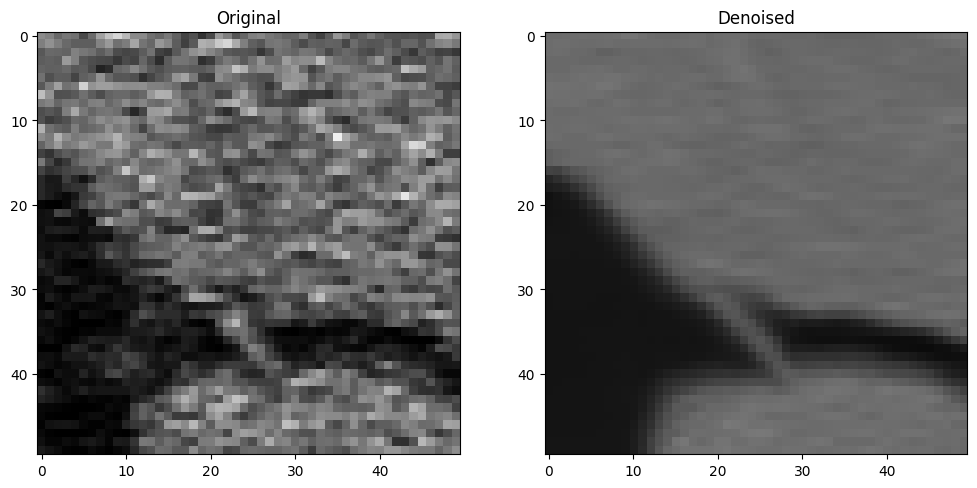

In [98]:
show_original_with_denoised(img_0, denoised_img_0)

In [101]:
compare_img_quality(img_0, crop(img_gt_float), denoised_img_0)

# PSNR
  66.46068772206652
  72.76136846251966
# SSIM
  0.28493636298612834
  0.41188768885212695
# MSE
  0.01468965474817378
  0.003443051466961903


# Using history for missing data

In [102]:
mask = np.ones(img_0.shape)
mask[30:, :] = 0

In [104]:
# load history
count = 5
history = []
for c in range(1, 1 + count):
    history.append(crop((imread(samples_dark_path + f"{c}.png", as_gray=True).astype(np.float64)) / 255))
    
denoised_img_0_incomplete = denoise_nlm_incomplete_with_history(img_0, mask, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 1.0829296112060547s
2/50 rows done, elapsed time: 1.9921855926513672s
3/50 rows done, elapsed time: 2.949039936065674s
4/50 rows done, elapsed time: 3.9743618965148926s
5/50 rows done, elapsed time: 5.175942659378052s
6/50 rows done, elapsed time: 6.336061716079712s
7/50 rows done, elapsed time: 7.509807348251343s
8/50 rows done, elapsed time: 8.730137825012207s
9/50 rows done, elapsed time: 10.023808002471924s
10/50 rows done, elapsed time: 11.363452196121216s
11/50 rows done, elapsed time: 12.750792503356934s
12/50 rows done, elapsed time: 14.193825244903564s
13/50 rows done, elapsed time: 15.874769926071167s
14/50 rows done, elapsed time: 17.444359064102173s
15/50 rows done, elapsed time: 18.981701374053955s
16/50 rows done, elapsed time: 20.597548246383667s
17/50 rows done, elapsed time: 22.29263162612915s
18/50 rows done, elapsed time: 24.01263689994812s
19/50 rows done, elapsed time: 25.736964225769043s
20/50 rows done, elapsed time: 27.5736942291259

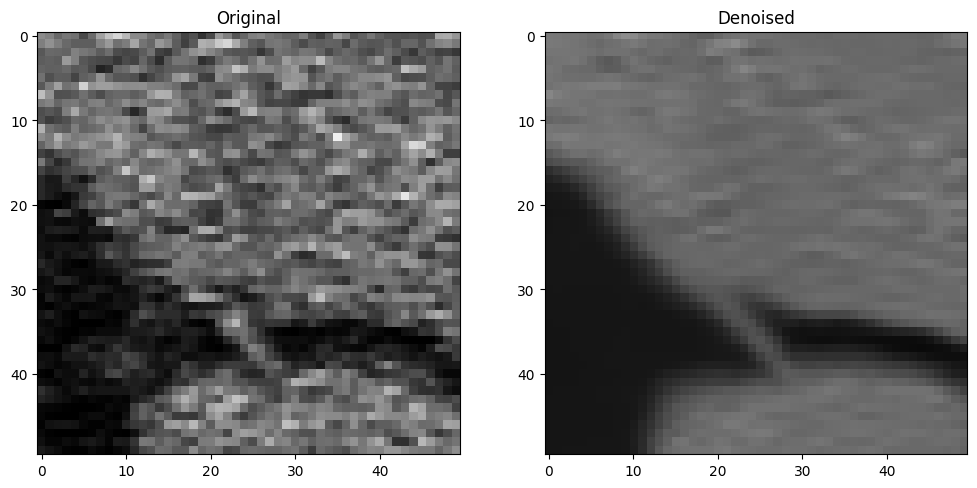

In [105]:
show_original_with_denoised(img_0, denoised_img_0_incomplete)

In [106]:
compare_img_quality(img_0, crop(img_gt_float), denoised_img_0_incomplete)

# PSNR
  66.46068772206652
  72.07674464768704
# SSIM
  0.28493636298612834
  0.4003229075069186
# MSE
  0.01468965474817378
  0.004030935937574306


# Chaning the window size


In [14]:
# PARAMETERS
sd = 0.1254076 # estimated using R
strength = 0.035 * sd # 0.078 
compare_window_size = 9 # ODD
search_window_size = 27 # ODD! bigger than compare win

In [15]:
denoised_img_smaller_sw = denoise_nlm_with_history(img_0, history, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.9697027206420898s
2/50 rows done, elapsed time: 1.8043057918548584s
3/50 rows done, elapsed time: 2.7129526138305664s
4/50 rows done, elapsed time: 3.6578962802886963s
5/50 rows done, elapsed time: 4.65824031829834s
6/50 rows done, elapsed time: 5.723234176635742s
7/50 rows done, elapsed time: 6.866822719573975s
8/50 rows done, elapsed time: 8.080047369003296s
9/50 rows done, elapsed time: 9.35397458076477s
10/50 rows done, elapsed time: 10.6792733669281s
11/50 rows done, elapsed time: 12.082062005996704s
12/50 rows done, elapsed time: 13.557191133499146s
13/50 rows done, elapsed time: 15.070066213607788s
14/50 rows done, elapsed time: 16.732842206954956s
15/50 rows done, elapsed time: 18.465851545333862s
16/50 rows done, elapsed time: 20.40853452682495s
17/50 rows done, elapsed time: 22.38346815109253s
18/50 rows done, elapsed time: 24.104730129241943s
19/50 rows done, elapsed time: 25.87551784515381s
20/50 rows done, elapsed time: 27.862390279769897s
2

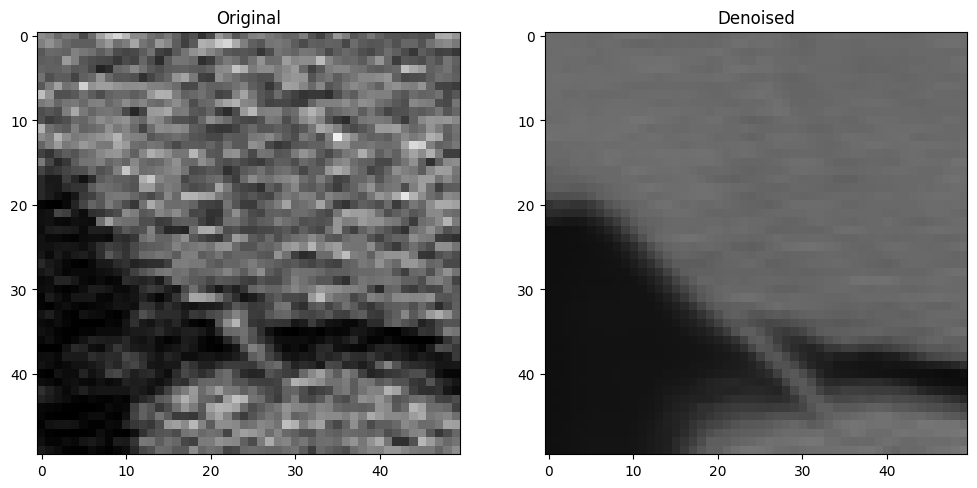

In [16]:
show_original_with_denoised(img_0, denoised_img_smaller_sw)

In [87]:
compare_img_quality(crop(img_float), crop(img_gt_float), denoised_img_smaller_sw)

# PSNR
  66.46068772206652
  65.53907533763254
# SSIM
  0.28493636298612834
  0.11657054262900185
# MSE
  0.01468965474817378
  0.018162382893988978


In [17]:
denoised_img_new = denoise_nlm(img_0, search_window_size, compare_window_size, strength, sd)

1/50 rows done, elapsed time: 0.3085012435913086s
2/50 rows done, elapsed time: 0.4245905876159668s
3/50 rows done, elapsed time: 0.5531940460205078s
4/50 rows done, elapsed time: 0.6900358200073242s
5/50 rows done, elapsed time: 0.8362479209899902s
6/50 rows done, elapsed time: 0.9909019470214844s
7/50 rows done, elapsed time: 1.16127347946167s
8/50 rows done, elapsed time: 1.3341538906097412s
9/50 rows done, elapsed time: 1.5215680599212646s
10/50 rows done, elapsed time: 1.7294025421142578s
11/50 rows done, elapsed time: 2.019249677658081s
12/50 rows done, elapsed time: 2.2409796714782715s
13/50 rows done, elapsed time: 2.4557178020477295s
14/50 rows done, elapsed time: 2.6842525005340576s
15/50 rows done, elapsed time: 2.9153854846954346s
16/50 rows done, elapsed time: 3.151590585708618s
17/50 rows done, elapsed time: 3.3805418014526367s
18/50 rows done, elapsed time: 3.608982563018799s
19/50 rows done, elapsed time: 3.8393616676330566s
20/50 rows done, elapsed time: 4.068099737167

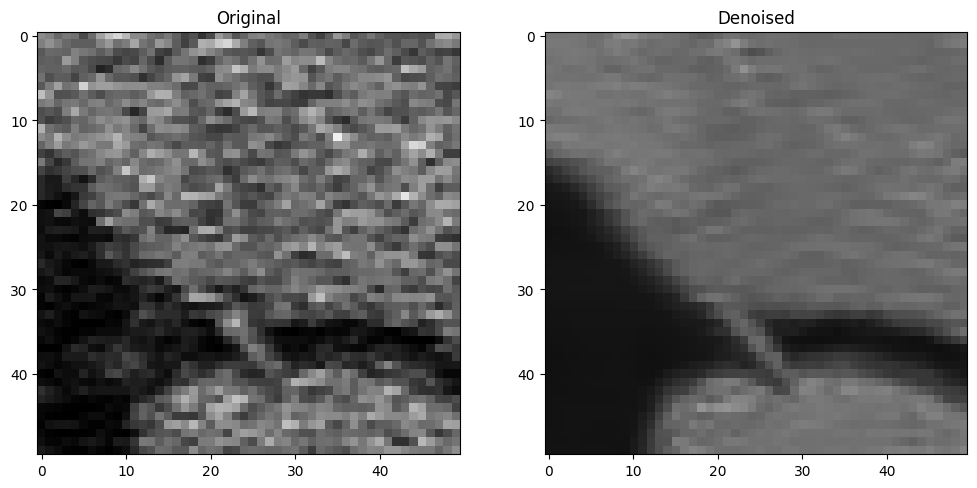

In [18]:
show_original_with_denoised(img_0, denoised_img_new)

# Reducing Search Window size
- This process may introduce spilling of colors, as shown above. 
- To find where is the "border" between number of history images and search window size is very problematic


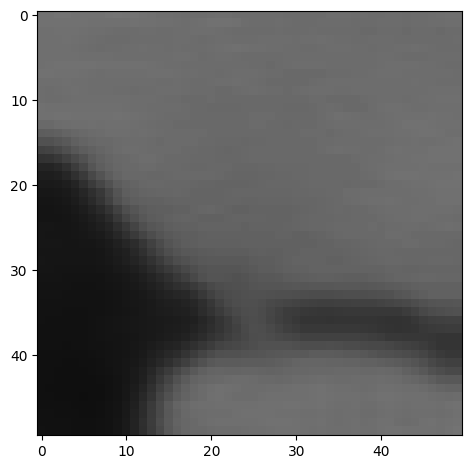

In [11]:
strength = 40
compare_window_size = 9
search_window_size = 27

cv_denoised_img = cv.fastNlMeansDenoising((img_0 * 255).astype(np.uint8), None, strength, compare_window_size, search_window_size)
imshow(cv_denoised_img)

In [13]:
# strength = 20
# noise_sd = 10
# compare_window_size = 31
# search_window_size = 101
#
# search_window_offset = int((search_window_size - 1) // 2)
# compare_window_offset = int((compare_window_size - 1) // 2)
# y_search_min = max(compare_window_offset,15 - search_window_offset)
# print(y_search_min)
#
# cv_denoised_img = cv.fastNlMeansDenoising(img, None, strength, compare_window_size, search_window_size)
# my_denoised_img = denoise_nlm(img, search_window_size, compare_window_size, strength, noise_sd)
#
#
# plt.figure(figsize=(12,6))
# plt.subplot(121).title.set_text('OpenCV NLM'), plt.imshow(cv_denoised_img, cmap='gray', vmin=0, vmax=255)
# plt.subplot(122).title.set_text('My NLM'), plt.imshow(my_denoised_img, cmap='gray', vmin=0, vmax=255)
# plt.show()